In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

### Load the dataset

In [2]:
def load_traffic_data(source, index_col, sep=','):
    '''
    Loads the traffic dataset to a pandas DataFrame and prints the shapes and column types.
    
        Args:
            source(str): the file path
            index_col(str): the row index column
            
        Returns:
            traffic_data(pd.DataFrame): the pandas traffic dataset
            
    '''
    traffic_data = pd.read_csv(source, index_col=index_col, sep=sep)
    print(traffic_data.shape)
    print(traffic_data.dtypes)
    return traffic_data

In [3]:
traffic_data = load_traffic_data('traffic_data.csv', index_col='Estimation_Time')

(1440, 14)
Weekday              object
Com_A               float64
Com_B               float64
Com_C               float64
Com_D               float64
Time_Period           int64
Busy                   bool
Roadwork_A            int64
Roadwork_B            int64
Roadwork_C            int64
Roadwork_D            int64
Congestion_level    float64
Sequence             object
Sequence_prev        object
dtype: object


In [4]:
traffic_data.head()

,Weekday,Com_A,Com_B,Com_C,Com_D,Time_Period,Busy,Roadwork_A,Roadwork_B,Roadwork_C,Roadwork_D,Congestion_level,Sequence,Sequence_prev
Estimation_Time,,,,,,,,,,,,,,
2019-09-01 00:00:00,Sunday,900.0,1350.0,1650.0,1950.0,4,False,0,0,0,0,0.01,E,E
2019-09-01 00:30:00,Sunday,900.0,1350.0,1650.0,1950.0,4,False,0,0,0,0,0.17,E,E
2019-09-01 01:00:00,Sunday,900.0,1350.0,1650.0,1950.0,4,False,0,0,0,0,0.47,E,E
2019-09-01 01:30:00,Sunday,900.0,1350.0,1650.0,1950.0,4,False,0,0,0,0,0.09,E,E
2019-09-01 02:00:00,Sunday,900.0,1350.0,1650.0,1950.0,4,False,0,0,0,0,0.03,E,E


### Train/test split

In [5]:
def create_features(traffic_data):
    '''
    Creates the Decision Tree inputs. Splits the dataset into attributes and output label,
    handles categorical data and prints out the result shapes and columns.
    
        Args:
            traffic_data(pd.DataFrame): the traffic dataset
            
        Returns:
            traffic_features(pd.DataFrame): the traffic attributes
            traffic_labels(pd.Series): the output sequence
            
    '''
    traffic_labels = traffic_data['Sequence']
    traffic_features = traffic_data.drop('Sequence', axis=1)
    print(traffic_features.shape, traffic_labels.shape)
    #### Convert day and previous sequence columns to categorical data
    traffic_features = pd.get_dummies(traffic_features)
    print('Result features:', traffic_features.columns)
    print('Result feature shape:', traffic_features.shape)
    return traffic_features, traffic_labels


def preprocess_data(traffic_features, traffic_labels):
    '''
    Performs train/test split with stratification. Prints the result set shapes and 
    returns them.
    
        Args:
            traffic_features(pd.DataFrame): the traffic attributes
            traffic_labels(pd.Series): the output sequence
            
        Returns:
            traffic_features_train(pd.DataFrame): traffic training attributes
            traffic_features_test(pd.DataFrame): traffic test attributes
            traffic_labels_train(pd.DataFrame): traffic train true sequences
            traffic_labels_test(pd.DataFrame): traffic test true sequences
            
    '''
    # split the data (with stratification due to imbalanced data)
    traffic_features_train, traffic_features_test, traffic_labels_train, traffic_labels_test = train_test_split(
        traffic_features,
        traffic_labels,
        train_size=0.7,
        test_size=0.3,
        stratify=traffic_labels,
        random_state=42)

    print('Training set feature/label shapes: ', traffic_features_train.shape,
          traffic_labels_train.shape)
    print('Test set feature/label shapes: ', traffic_features_test.shape,
          traffic_labels_test.shape)

    return traffic_features_train, traffic_labels_train, traffic_features_test, traffic_labels_test

In [6]:
traffic_features, traffic_labels = create_features(traffic_data)
traffic_features_train, traffic_labels_train, traffic_features_test, traffic_labels_test = preprocess_data(
    traffic_features, traffic_labels)

(1440, 13) (1440,)
Result features: Index(['Com_A', 'Com_B', 'Com_C', 'Com_D', 'Time_Period', 'Busy', 'Roadwork_A',
       'Roadwork_B', 'Roadwork_C', 'Roadwork_D', 'Congestion_level',
       'Weekday_Friday', 'Weekday_Monday', 'Weekday_Saturday',
       'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday',
       'Weekday_Wednesday', 'Sequence_prev_ADCB', 'Sequence_prev_BADC',
       'Sequence_prev_CBAD', 'Sequence_prev_DCBA', 'Sequence_prev_E'],
      dtype='object')
Result feature shape: (1440, 23)
Training set feature/label shapes:  (1007, 23) (1007,)
Test set feature/label shapes:  (432, 23) (432,)


### Create the classifier and predict some examples

#### Baseline

In [7]:
def fit_and_eval_tree(features_train, features_test, labels_train,
                      labels_test):
    '''
    Creates a baseline Decision Tree classifier. Fits it to the training data and evaluates
    it on the train/test data based on F1-Score. Prints a classification report and 
    confusion matrix for the classifier.
    
        Args:
            features_train(pd.DataFrame): traffic training attributes
            features_test(pd.DataFrame): traffic test attributes
            labels_train(pd.DataFrame): traffic train true sequences
            labels_test(pd.DataFrame): traffic test true sequences
            
        Returns:
            tree_classifier(DecisionTreeClassifier): the trained Decision Tree
            
    '''
    tree_classifier = DecisionTreeClassifier()
    tree_classifier.fit(features_train, labels_train)
    tree_preds_train = tree_classifier.predict(features_train)
    tree_preds_test = tree_classifier.predict(features_test)
    print(('F1 score for baseline model (training set): ',
          f1_score(labels_train, tree_preds_train, average='micro')))
    print(('F1 score for baseline model (test set): ',
          f1_score(labels_test, tree_preds_test, average='micro')))
    print('Classification report for training data.')
    print((
        classification_report(
            labels_train,
            tree_preds_train,
            target_names=['ADCB', 'BADC', 'CBAD', 'DCBA', 'E'])))
    print('Classification report for test data.')
    print((
        classification_report(
            labels_test,
            tree_preds_test,
            target_names=['ADCB', 'BADC', 'CBAD', 'DCBA', 'E'])))
    print('Confusion matrix for test data.')
    cm = confusion_matrix(labels_test, tree_preds_test)
    print(cm)
    return tree_classifier

In [8]:
tree_classifier = fit_and_eval_tree(traffic_features_train, traffic_features_test, traffic_labels_train, traffic_labels_test)

('F1 score for baseline model (training set): ', 1.0)
('F1 score for baseline model (test set): ', 0.9837962962962963)
Classification report for training data.
              precision    recall  f1-score   support

        ADCB       1.00      1.00      1.00        74
        BADC       1.00      1.00      1.00        64
        CBAD       1.00      1.00      1.00        92
        DCBA       1.00      1.00      1.00        98
           E       1.00      1.00      1.00       679

    accuracy                           1.00      1007
   macro avg       1.00      1.00      1.00      1007
weighted avg       1.00      1.00      1.00      1007

Classification report for test data.
              precision    recall  f1-score   support

        ADCB       0.97      0.97      0.97        32
        BADC       0.96      1.00      0.98        27
        CBAD       0.97      0.93      0.95        40
        DCBA       0.91      0.98      0.94        42
           E       1.00      0.99      1.00

#### Export baseline tree

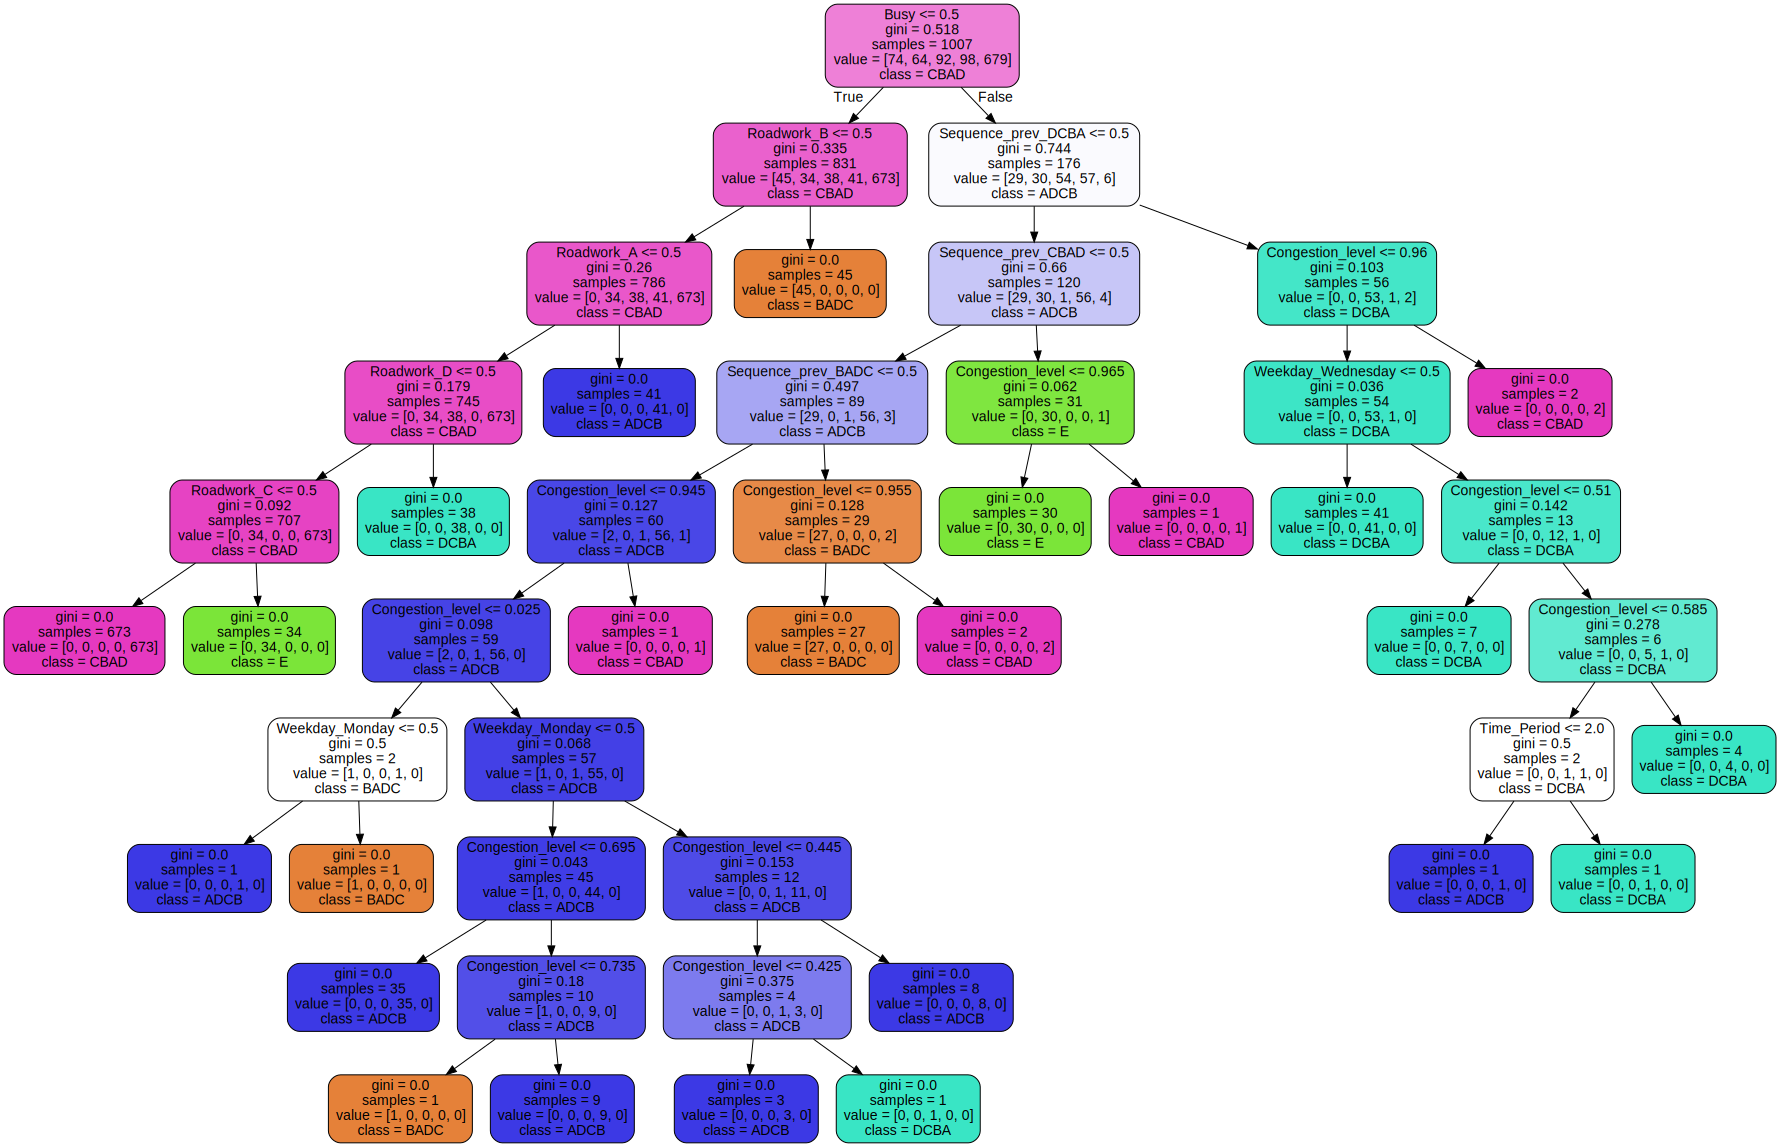

In [9]:
from graphviz import Source
from sklearn.tree import export_graphviz
import os
import pydot

export_graphviz(
        tree_classifier,
        out_file="decision_tree_base.dot",
        feature_names=traffic_features.columns,
        class_names=list(set(traffic_labels)),
        rounded=True,
        filled=True
    )

Source.from_file("decision_tree_base.dot")

In [10]:
(graph,) = pydot.graph_from_dot_file('decision_tree_base.dot')
graph.write_png('decision_tree_base.png')

#### Predict future sequences

In [11]:
sample_1 = pd.DataFrame(traffic_data.loc['2019-09-11 08:30:00']).T
sample_2 = pd.DataFrame(traffic_data.loc['2019-09-11 09:00:00']).T
sample_3 = pd.DataFrame(traffic_data.loc['2019-09-15 11:00:00']).T
sample_4 = pd.DataFrame(traffic_data.loc['2019-09-11 16:30:00']).T
sample_5 = pd.DataFrame(traffic_data.loc['2019-09-15 17:00:00']).T

In [12]:
import datetime
dt1 = datetime.datetime(2019, 10, 11, 8, 30, 0)
dt1_dt = dt1.strftime('%Y-%m-%d %H:%M:%S')
dt_list = [dt1]
sample_1.index = dt_list

dt1 = datetime.datetime(2019, 10, 11, 9, 0, 0)
dt1_dt = dt1.strftime('%Y-%m-%d %H:%M:%S')
dt_list = [dt1]
sample_2.index = dt_list

dt1 = datetime.datetime(2019, 10, 15, 11, 0, 0)
dt1_dt = dt1.strftime('%Y-%m-%d %H:%M:%S')
dt_list = [dt1]
sample_3.index = dt_list

dt1 = datetime.datetime(2019, 10, 11, 16, 30, 0)
dt1_dt = dt1.strftime('%Y-%m-%d %H:%M:%S')
dt_list = [dt1]
sample_4.index = dt_list

dt1 = datetime.datetime(2019, 10, 15, 17, 0, 0)
dt1_dt = dt1.strftime('%Y-%m-%d %H:%M:%S')
dt_list = [dt1]
sample_5.index = dt_list

In [13]:
samples = pd.concat([sample_1, sample_2, sample_3, sample_4, sample_5])

In [14]:
samples['Com_A'] = samples['Com_A'].astype(np.float64)
samples['Com_B'] = samples['Com_B'].astype(np.float64)
samples['Com_C'] = samples['Com_C'].astype(np.float64)
samples['Com_D'] = samples['Com_D'].astype(np.float64)
samples['Time_Period'] = samples['Time_Period'].astype(np.int64)
samples['Congestion_level'] = samples['Congestion_level'].astype(np.float64)
samples['Roadwork_A'] = samples['Roadwork_A'].astype(np.int64)
samples['Roadwork_B'] = samples['Roadwork_B'].astype(np.int64)
samples['Roadwork_C'] = samples['Roadwork_C'].astype(np.int64)
samples['Roadwork_D'] = samples['Roadwork_D'].astype(np.int64)

In [15]:
samples['Weekday_Monday'] = 0
samples['Weekday_Tuesday'] = 0
samples['Weekday_Thursday'] = 0
samples['Weekday_Friday'] = 0
samples['Weekday_Saturday'] = 0

In [16]:
samples.columns

Index(['Weekday', 'Com_A', 'Com_B', 'Com_C', 'Com_D', 'Time_Period', 'Busy',
       'Roadwork_A', 'Roadwork_B', 'Roadwork_C', 'Roadwork_D',
       'Congestion_level', 'Sequence', 'Sequence_prev', 'Weekday_Monday',
       'Weekday_Tuesday', 'Weekday_Thursday', 'Weekday_Friday',
       'Weekday_Saturday'],
      dtype='object')

In [17]:
samples

,Weekday,Com_A,Com_B,Com_C,Com_D,Time_Period,Busy,Roadwork_A,Roadwork_B,Roadwork_C,Roadwork_D,Congestion_level,Sequence,Sequence_prev,Weekday_Monday,Weekday_Tuesday,Weekday_Thursday,Weekday_Friday,Weekday_Saturday
2019-10-11 08:30:00,Wednesday,1500.0,2250.0,2750.0,3250.0,1,True,0,0,0,0,0.17,ADCB,BADC,0,0,0,0,0
2019-10-11 09:00:00,Wednesday,1500.0,2250.0,2750.0,3250.0,1,True,0,0,0,0,0.20,DCBA,ADCB,0,0,0,0,0
2019-10-15 11:00:00,Sunday,900.0,1350.0,1650.0,1950.0,4,False,0,1,0,0,0.15,ADCB,E,0,0,0,0,0
2019-10-11 16:30:00,Wednesday,1500.0,2250.0,2750.0,3250.0,3,True,0,0,0,0,0.64,CBAD,DCBA,0,0,0,0,0
2019-10-15 17:00:00,Sunday,900.0,1350.0,1650.0,1950.0,4,False,1,0,0,0,0.34,DCBA,E,0,0,0,0,0


In [18]:
samples_labels = samples['Sequence']
samples_features = samples.drop('Sequence', axis=1)

In [19]:
samples_normalized = pd.get_dummies(samples_features)

In [20]:
samples = samples.drop('Weekday', axis=1)

In [21]:
samples_normalized

,Com_A,Com_B,Com_C,Com_D,Time_Period,Roadwork_A,Roadwork_B,Roadwork_C,Roadwork_D,Congestion_level,...,Weekday_Friday,Weekday_Saturday,Weekday_Sunday,Weekday_Wednesday,Busy_False,Busy_True,Sequence_prev_ADCB,Sequence_prev_BADC,Sequence_prev_DCBA,Sequence_prev_E
2019-10-11 08:30:00,1500.0,2250.0,2750.0,3250.0,1,0,0,0,0,0.17,...,0,0,0,1,0,1,0,1,0,0
2019-10-11 09:00:00,1500.0,2250.0,2750.0,3250.0,1,0,0,0,0,0.20,...,0,0,0,1,0,1,1,0,0,0
2019-10-15 11:00:00,900.0,1350.0,1650.0,1950.0,4,0,1,0,0,0.15,...,0,0,1,0,1,0,0,0,0,1
2019-10-11 16:30:00,1500.0,2250.0,2750.0,3250.0,3,0,0,0,0,0.64,...,0,0,0,1,0,1,0,0,1,0
2019-10-15 17:00:00,900.0,1350.0,1650.0,1950.0,4,1,0,0,0,0.34,...,0,0,1,0,1,0,0,0,0,1


In [22]:
samples_normalized[samples_normalized['Weekday_Wednesday'] == 1]

,Com_A,Com_B,Com_C,Com_D,Time_Period,Roadwork_A,Roadwork_B,Roadwork_C,Roadwork_D,Congestion_level,...,Weekday_Friday,Weekday_Saturday,Weekday_Sunday,Weekday_Wednesday,Busy_False,Busy_True,Sequence_prev_ADCB,Sequence_prev_BADC,Sequence_prev_DCBA,Sequence_prev_E
2019-10-11 08:30:00,1500.0,2250.0,2750.0,3250.0,1,0,0,0,0,0.17,...,0,0,0,1,0,1,0,1,0,0
2019-10-11 09:00:00,1500.0,2250.0,2750.0,3250.0,1,0,0,0,0,0.20,...,0,0,0,1,0,1,1,0,0,0
2019-10-11 16:30:00,1500.0,2250.0,2750.0,3250.0,3,0,0,0,0,0.64,...,0,0,0,1,0,1,0,0,1,0


In [23]:
print(samples_normalized.columns)

Index(['Com_A', 'Com_B', 'Com_C', 'Com_D', 'Time_Period', 'Roadwork_A',
       'Roadwork_B', 'Roadwork_C', 'Roadwork_D', 'Congestion_level',
       'Weekday_Monday', 'Weekday_Tuesday', 'Weekday_Thursday',
       'Weekday_Friday', 'Weekday_Saturday', 'Weekday_Sunday',
       'Weekday_Wednesday', 'Busy_False', 'Busy_True', 'Sequence_prev_ADCB',
       'Sequence_prev_BADC', 'Sequence_prev_DCBA', 'Sequence_prev_E'],
      dtype='object')


In [24]:
print(samples_normalized.shape, samples_labels.shape)

(5, 23) (5,)


In [25]:
samples_pred = tree_classifier.predict(samples_normalized)

In [26]:
for i in range(len(samples_normalized)):
    print('Prediction for sample {}: Input step({}), Sequence({})'.format(
        i, samples_normalized.index[i], samples_pred[i]))

Prediction for sample 0: Input step(2019-10-11 08:30:00), Sequence(E)
Prediction for sample 1: Input step(2019-10-11 09:00:00), Sequence(E)
Prediction for sample 2: Input step(2019-10-15 11:00:00), Sequence(DCBA)
Prediction for sample 3: Input step(2019-10-11 16:30:00), Sequence(CBAD)
Prediction for sample 4: Input step(2019-10-15 17:00:00), Sequence(DCBA)


### Training with only discrete features (removing previous sequence)
This should decrease performance, but it's done to make sure the decision tree is actually learning useful information from the rest of the features, instead of just looking at the previous sequences.

In [27]:
traffic_features = traffic_features.drop([
    'Sequence_prev_DCBA', 'Sequence_prev_CBAD', 'Sequence_prev_BADC',
    'Sequence_prev_ADCB', 'Sequence_prev_E'
], axis=1)

In [28]:
traffic_features.head()

,Com_A,Com_B,Com_C,Com_D,Time_Period,Busy,Roadwork_A,Roadwork_B,Roadwork_C,Roadwork_D,Congestion_level,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
Estimation_Time,,,,,,,,,,,,,,,,,,
2019-09-01 00:00:00,900.0,1350.0,1650.0,1950.0,4,False,0,0,0,0,0.01,0,0,0,1,0,0,0
2019-09-01 00:30:00,900.0,1350.0,1650.0,1950.0,4,False,0,0,0,0,0.17,0,0,0,1,0,0,0
2019-09-01 01:00:00,900.0,1350.0,1650.0,1950.0,4,False,0,0,0,0,0.47,0,0,0,1,0,0,0
2019-09-01 01:30:00,900.0,1350.0,1650.0,1950.0,4,False,0,0,0,0,0.09,0,0,0,1,0,0,0
2019-09-01 02:00:00,900.0,1350.0,1650.0,1950.0,4,False,0,0,0,0,0.03,0,0,0,1,0,0,0


In [29]:
traffic_features_train, traffic_labels_train, traffic_features_test, traffic_labels_test = preprocess_data(
    traffic_features, traffic_labels)

Training set feature/label shapes:  (1007, 18) (1007,)
Test set feature/label shapes:  (432, 18) (432,)


In [30]:
fit_and_eval_tree(traffic_features_train, traffic_features_test,
                  traffic_labels_train, traffic_labels_test)

('F1 score for baseline model (training set): ', 0.9900695134061569)
('F1 score for baseline model (test set): ', 0.875)
Classification report for training data.
              precision    recall  f1-score   support

        ADCB       0.94      1.00      0.97        74
        BADC       0.97      0.95      0.96        64
        CBAD       0.98      0.98      0.98        92
        DCBA       0.99      0.95      0.97        98
           E       1.00      1.00      1.00       679

    accuracy                           0.99      1007
   macro avg       0.97      0.98      0.97      1007
weighted avg       0.99      0.99      0.99      1007

Classification report for test data.
              precision    recall  f1-score   support

        ADCB       0.62      0.72      0.67        32
        BADC       0.57      0.78      0.66        27
        CBAD       0.67      0.50      0.57        40
        DCBA       0.62      0.55      0.58        42
           E       1.00      1.00      1.

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

#### Optimization step (grid search with K-fold cross validation)

In [31]:
# K-fold CV (K=5)
k_fold = StratifiedKFold(n_splits=5)

In [32]:
params = {'max_depth': [1, 5, 7, 15, 20],
          'min_samples_leaf': [2, 5, 10, 12],
          'max_leaf_nodes': [5, 10, 20],
          'criterion': ['gini', 'entropy']}

In [33]:
grid_search = GridSearchCV(estimator=tree_classifier,
                           param_grid=params,
                           scoring=make_scorer(f1_score, average='micro'),
                           cv=k_fold)

In [34]:
grid_search.fit(traffic_features_train, traffic_labels_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
    

In [35]:
print("Grid Search Results:")
print("Best estimator: ", grid_search.best_estimator_)
print("Best parameters: ", grid_search.best_params_)
print("Best F1 Score on test set: ", grid_search.best_score_)

Grid Search Results:
Best estimator:  DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
Best parameters:  {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 10, 'min_samples_leaf': 5}
Best F1 Score on test set:  0.8887785501489573


In [36]:
tree_preds_train = grid_search.predict(traffic_features_train)
tree_preds_test = grid_search.predict(traffic_features_test)

In [37]:
print('Classification report for training data.')
print(classification_report(traffic_labels_train, tree_preds_train, target_names=['ADCB', 'BADC', 'CBAD', 'DCBA', 'E']))
print('Classification report for test data.')
print(classification_report(traffic_labels_test, tree_preds_test, target_names=['ADCB', 'BADC', 'CBAD', 'DCBA', 'E']))
print('Confusion matrix for test data.')
cm = confusion_matrix(traffic_labels_test, tree_preds_test)
print(cm)

Classification report for training data.
              precision    recall  f1-score   support

        ADCB       0.86      0.66      0.75        74
        BADC       1.00      0.53      0.69        64
        CBAD       0.56      0.86      0.68        92
        DCBA       0.70      0.68      0.69        98
           E       1.00      1.00      1.00       679

    accuracy                           0.90      1007
   macro avg       0.82      0.75      0.76      1007
weighted avg       0.92      0.90      0.90      1007

Classification report for test data.
              precision    recall  f1-score   support

        ADCB       0.96      0.75      0.84        32
        BADC       1.00      0.67      0.80        27
        CBAD       0.57      0.72      0.64        40
        DCBA       0.57      0.64      0.61        42
           E       1.00      1.00      1.00       291

    accuracy                           0.90       432
   macro avg       0.82      0.76      0.78       432

In [38]:
# function taken from sklearn tutorials
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig, ax = plt.subplots(figsize=(10,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.75       0.         0.09375    0.15625    0.        ]
 [0.         0.66666667 0.14814815 0.18518519 0.        ]
 [0.025      0.         0.725      0.25       0.        ]
 [0.         0.         0.35714286 0.64285714 0.        ]
 [0.         0.         0.         0.         1.        ]]


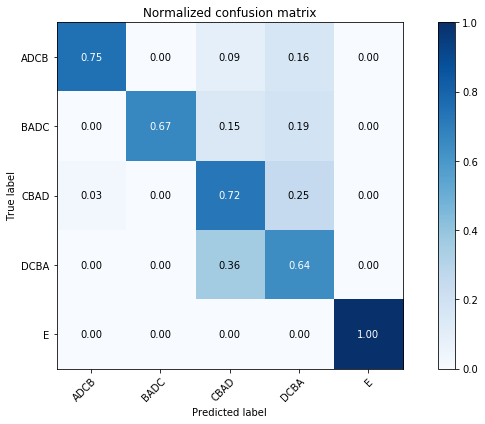

In [39]:
plot_confusion_matrix(traffic_labels_test, tree_preds_test, classes=['ADCB', 'BADC', 'CBAD', 'DCBA', 'E'], 
                     normalize=True)

#### Export optimized tree

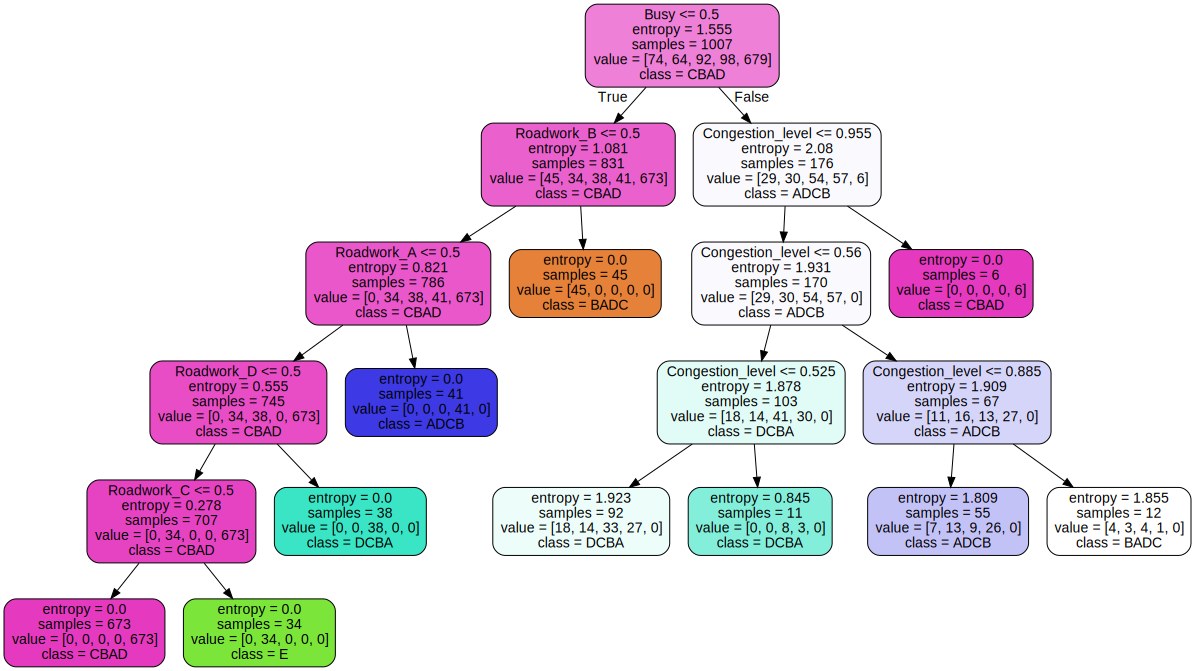

In [40]:
export_graphviz(
        grid_search.best_estimator_,
        out_file="decision_tree_gs.dot",
        feature_names=traffic_features.columns,
        class_names=list(set(traffic_labels)),
        rounded=True,
        filled=True
    )

Source.from_file("decision_tree_gs.dot")

In [41]:
(graph,) = pydot.graph_from_dot_file('decision_tree_gs.dot')
graph.write_png('decision_tree_gs.png')